In [14]:
import os, subprocess
from pathlib import Path

In [15]:
def get_current_dir_fun() -> str:
    return "exec('import os') or (str(globals()['_dh'][0]) if globals().get('_dh') else os.path.dirname(os.path.realpath(__file__)))"

def get_free_gpu_id() -> str:
    GPU_ID = subprocess.getoutput(
        'nvidia-smi --query-gpu=memory.free --format=csv,nounits,noheader | nl -v 0 | sort -nrk 2 | cut -f 1| head -n 1 | xargs')
    return GPU_ID

In [16]:
__current_dir__ = eval(get_current_dir_fun())
mmseg_path = str(Path(__current_dir__).parent)
os.chdir(mmseg_path)
print(f'Change work directory to: {mmseg_path}')

os.environ['CUDA_VISIBLE_DEVICES'] = get_free_gpu_id()
print(f'USE GPU: {os.environ["CUDA_VISIBLE_DEVICES"]}')

Change work directory to: /home/zhongxi/clone/DocumentImageTamperingDetection/ECCV-FFDN
USE GPU: 7


In [17]:
import time
import torch
from mmengine import Config
from mmengine.model.utils import revert_sync_batchnorm
from mmengine.registry import init_default_scope
from mmengine.runner import Runner, load_checkpoint
from mmseg.registry import MODELS
from matplotlib import pyplot as plt

### Download the pretrained model

In [18]:
ckpt_file = 'pretrained_models/FFDN.pth'

In [19]:
# Check dataset structure:
# data
# └── DocTamperV1
#     ├── unzip_files
#     │   ├── DocTamperV1-TrainingSet
#     │   ├── DocTamperV1-TestingSet
#     │   ├── DocTamperV1-FCD
#     │   └── DocTamperV1-SCD
#     ├── pks
#     │   ├── DocTamperV1-TestingSet_75.pk
#     │   ├── DocTamperV1-FCD_75.pk
#     │   └── DocTamperV1-SCD_75.pk
#     └── processed
#         ├── train.txt
#         ├── val.txt
#         ├── fcd.txt
#         └── scd.txt

assert os.path.exists('./data/DocTamperV1/processed/val.txt')
assert os.path.exists('./data/DocTamperV1/pks/DocTamperV1-TestingSet_75.pk')
assert os.path.exists('./data/DocTamperV1/unzip_files/DocTamperV1-TestingSet'), 'Dataset not found, please download the dataset first'

In [20]:
# build dataloader

config_file = 'work_config/FFDN/FFDN_inference.py'
cfg = Config.fromfile(config_file)

init_default_scope(cfg.get('default_scope', 'mmseg'))
cfg.model.data_preprocessor.binary_seg = False
timestamp = time.strftime('%Y%m%d_%H%M%S', time.localtime())

cfg.model.pretrained = None
cfg.model.train_cfg = None

In [21]:
test_loader_cfg = """{'batch_size': 1,
 'num_workers': 4,
 'persistent_workers': True,
 'sampler': {'type': 'DefaultSampler', 'shuffle': False},
 'dataset': {'type': 'BaseSegDataset',
  'data_root': './data/DocTamperV1',
  'ann_file': 'processed/val.txt',
  'img_suffix': '.jpg',
  'seg_map_suffix': '.png',
  'metainfo': {'task_name': 'doc_tamper_segmentation',
   'classes': ['untamper', 'tamper'],
   'palette': [[0, 0, 0], [255, 255, 255]]},
  'test_mode': True,
  'pipeline': [{'type': 'LoadImageLabelFromFileLMDB',
    'file_client_args': {'db_path': './data/DocTamperV1/unzip_files/DocTamperV1-TestingSet'}},
   {'type': 'Resize', 'scale': (512, 512), 'keep_ratio': True},
   {'type': 'RandomJpegCompressAndLoadInfo',
    'load_info': True,
    'return_rgb': True,
    'compress_pk': './data/DocTamperV1/pks/DocTamperV1-TestingSet_75.pk'},
   {'type': 'PackSegInputs',
    'meta_keys': ('img_path',
     'seg_map_path',
     'ori_shape',
     'img_shape',
     'pad_shape',
     'scale_factor',
     'flip',
     'flip_direction',
     'reduce_zero_label',
     'dct',
     'qtb')}]}}"""

In [22]:
data_loader = Runner.build_dataloader(eval(test_loader_cfg))

In [23]:
# build model
model = MODELS.build(cfg.model)
if hasattr(model, 'auxiliary_head'):
    model.auxiliary_head = None
if torch.cuda.is_available():
    model = model.cuda()

model = revert_sync_batchnorm(model)

model.eval()

EncoderDecoder(
  (data_preprocessor): SegDataPreProcessor()
  (backbone): TimmDct(
    (timm_model): ConvNeXt(
      (stem): Sequential(
        (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
      )
      (stages): Sequential(
        (0): ConvNeXtStage(
          (downsample): Identity()
          (blocks): Sequential(
            (0): ConvNeXtBlock(
              (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
              (norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
              (mlp): GlobalResponseNormMlp(
                (fc1): Linear(in_features=128, out_features=512, bias=True)
                (act): GELU()
                (drop1): Dropout(p=0.0, inplace=False)
                (grn): GlobalResponseNorm()
                (fc2): Linear(in_features=512, out_features=128, bias=True)
                (drop2): Dropout(p=0.0, inplace=False)
      

In [24]:
load_checkpoint(model, ckpt_file, map_location='cpu')
print(f'Load checkpoint from: {ckpt_file}')

Loads checkpoint by local backend from path: pretrained_models/FFDN.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: auxiliary_head.conv_seg.weight, auxiliary_head.conv_seg.bias, auxiliary_head.convs.0.conv.weight, auxiliary_head.convs.0.bn.weight, auxiliary_head.convs.0.bn.bias, auxiliary_head.convs.0.bn.running_mean, auxiliary_head.convs.0.bn.running_var, auxiliary_head.convs.0.bn.num_batches_tracked, neck.neck.AGFG_HH.GF1.ARB.mean_conv1.conv2d.weight, neck.neck.AGFG_HH.GF1.ARB.mean_conv1.conv2d.bias, neck.neck.AGFG_HH.GF1.ARB.mean_conv2.conv2d.weight, neck.neck.AGFG_HH.GF1.ARB.mean_conv2.conv2d.bias, neck.neck.AGFG_HH.GF1.ARB.mean_conv3.conv2d.weight, neck.neck.AGFG_HH.GF1.ARB.mean_conv3.conv2d.bias, neck.neck.AGFG_HH.GF1.ARB.std_conv1.conv2d.weight, neck.neck.AGFG_HH.GF1.ARB.std_conv1.conv2d.bias, neck.neck.AGFG_HH.GF1.ARB.std_conv2.conv2d.weight, neck.neck.AGFG_HH.GF1.ARB.std_conv2.conv2d.bias, neck.neck.AGFG_HH.GF1.ARB.std_conv3.conv2

In [25]:
data_iter = iter(data_loader) if globals().get('data_iter') is None else data_iter
example_data = next(data_iter)

example_data = model.data_preprocessor(example_data)
outs = model(example_data['inputs'], example_data['data_samples'], mode='predict')

gts = [data.gt_sem_seg.data for data in example_data['data_samples']]
segs = [out.pred_sem_seg.data for out in outs]

### Visualize the segmentation results

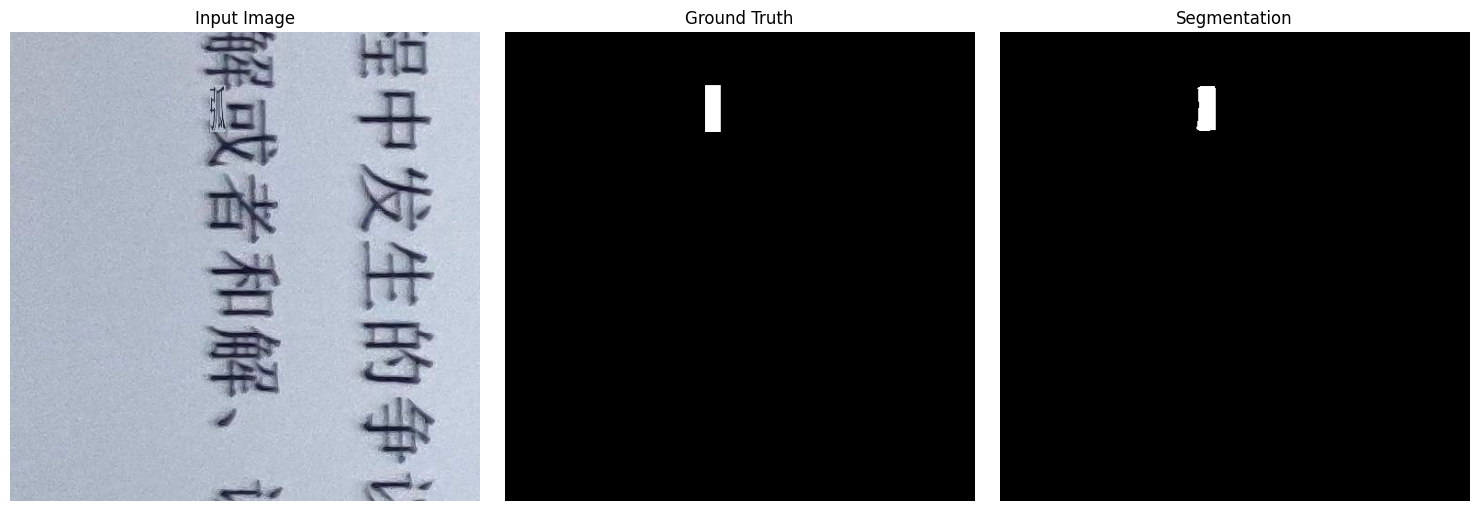

In [26]:
input_image = example_data['inputs']['x'].cpu().squeeze(0).permute(1, 2, 0).numpy()
input_image = (input_image - input_image.min()) / (input_image.max() - input_image.min())
gt_image = gts[0].cpu().squeeze(0).numpy()
seg_image = segs[0].cpu().squeeze(0).numpy()

# Create a figure with 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot input image
ax1.imshow(input_image)
ax1.set_title('Input Image')
ax1.axis('off')

# Plot ground truth
ax2.imshow(gt_image, cmap='gray')
ax2.set_title('Ground Truth')
ax2.axis('off')

# Plot segmentation
ax3.imshow(seg_image, cmap='gray')
ax3.set_title('Segmentation')
ax3.axis('off')

plt.tight_layout()
plt.show()